# Brain Tumor Segmentation - Demo Notebook

This notebook demonstrates the trained U-Net model for brain tumor segmentation from MRI scans.

**Model Performance:**
- Validation Dice: 87.95%
- Validation IoU: 79.93%
- Validation Accuracy: 99.60%

**Trained on:** January 26, 2026 (50 epochs, BCEDiceLoss)

In [1]:
# Import libraries
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from torch.utils.data import DataLoader

sys.path.append(str(Path.cwd().parent))

from src.models.unet import UNet
from src.models.metrics import SegmentationMetrics
from src.data.dataset import BrainTumorDataset

plt.style.use('default')
%matplotlib inline

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Libraries imported successfully
PyTorch version: 2.10.0+cu128
CUDA available: True


## 1. Load Trained Model

Loading the best U-Net model from training checkpoint.

In [2]:
# Configuration
CHECKPOINT_PATH = '../models/checkpoints/best_model.pth'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 128

# Initialize model
model = UNet(in_channels=3, out_channels=1, features=64)

# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)
model.eval()

print(f"✓ Model loaded from {CHECKPOINT_PATH}")
print(f"✓ Device: {DEVICE}")
print(f"✓ Model parameters: {model.count_parameters():,}")
print(f"\nCheckpoint metrics:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Val Dice: {checkpoint['metrics']['dice']:.4f}")
print(f"  Val IoU: {checkpoint['metrics']['iou']:.4f}")
print(f"  Val Accuracy: {checkpoint['metrics']['accuracy']:.4f}")

✓ Model loaded from ../models/checkpoints/best_model.pth
✓ Device: cuda
✓ Model parameters: 31,043,521

Checkpoint metrics:
  Epoch: 38
  Val Dice: 0.8795
  Val IoU: 0.8032
  Val Accuracy: 0.9961


## 2. Load Test Dataset

Loading brain tumor MRI images and segmentation masks.


In [3]:
# Load dataset (using classes 1, 2, 3 - excluding no-tumor)
DATA_DIR = '../data/raw/Brain-Tumor-Segmentation-Dataset'

dataset = BrainTumorDataset(
    data_dir=DATA_DIR,
    image_size=IMAGE_SIZE,
    classes=[1, 2, 3]
)

print(f"✓ Dataset loaded: {len(dataset)} samples")
print(f"✓ Class distribution: {dataset.get_class_distribution()}")

test_loader = DataLoader(dataset, batch_size=4, shuffle=True)


✓ Dataset loaded: 2349 samples
✓ Class distribution: {1: 649, 2: 999, 3: 701}


## 3. Inference Function

Helper function to run model predictions and calculate metrics.

In [4]:
def run_inference(model, image, device=DEVICE, threshold=0.5):
    """Run inference on a single image."""
    model.eval()
    with torch.no_grad():
        if len(image.shape) == 3:
            image = image.unsqueeze(0) 
        
        image = image.to(device)
        output = model(image)
        prediction = (output > threshold).float()
        
    return prediction.squeeze(0).cpu()

def calculate_metrics(pred, target):
    """Calculate Dice and IoU for a prediction."""
    metrics = SegmentationMetrics()
    
    if len(pred.shape) == 2:
        pred = pred.unsqueeze(0).unsqueeze(0)
    elif len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
        
    if len(target.shape) == 2:
        target = target.unsqueeze(0).unsqueeze(0)
    elif len(target.shape) == 3:
        target = target.unsqueeze(0)
    
    results = metrics(pred, target)
    return results['dice'], results['iou']


## 4. Visualization Function

Create side-by-side comparison of Original | Ground Truth | Prediction

In [5]:
def visualize_segmentation(image, mask, prediction, dice=None, iou=None, idx=None):
    """Visualize original image, ground truth mask, and prediction."""
    
    # Convert tensors to numpy
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze(0).numpy()
    pred_np = prediction.squeeze(0).numpy()
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image_np)
    axes[0].set_title('Original MRI', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Ground truth mask
    axes[1].imshow(image_np)
    axes[1].imshow(mask_np, alpha=0.5, cmap='Reds')
    axes[1].set_title('Ground Truth', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Prediction
    axes[2].imshow(image_np)
    axes[2].imshow(pred_np, alpha=0.5, cmap='Blues')
    title = 'Model Prediction'
    if dice is not None and iou is not None:
        title += f'\nDice: {dice:.3f} | IoU: {iou:.3f}'
    axes[2].set_title(title, fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    if idx is not None:
        fig.suptitle(f'Sample #{idx}', fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined")

✓ Visualization function defined


## 5. Single Sample Demo

Let's test on a single sample first.

Sample index: 1890
Image shape: torch.Size([3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Tumor present: True

Metrics:
  Dice Score: 0.9752
  IoU Score: 0.9516


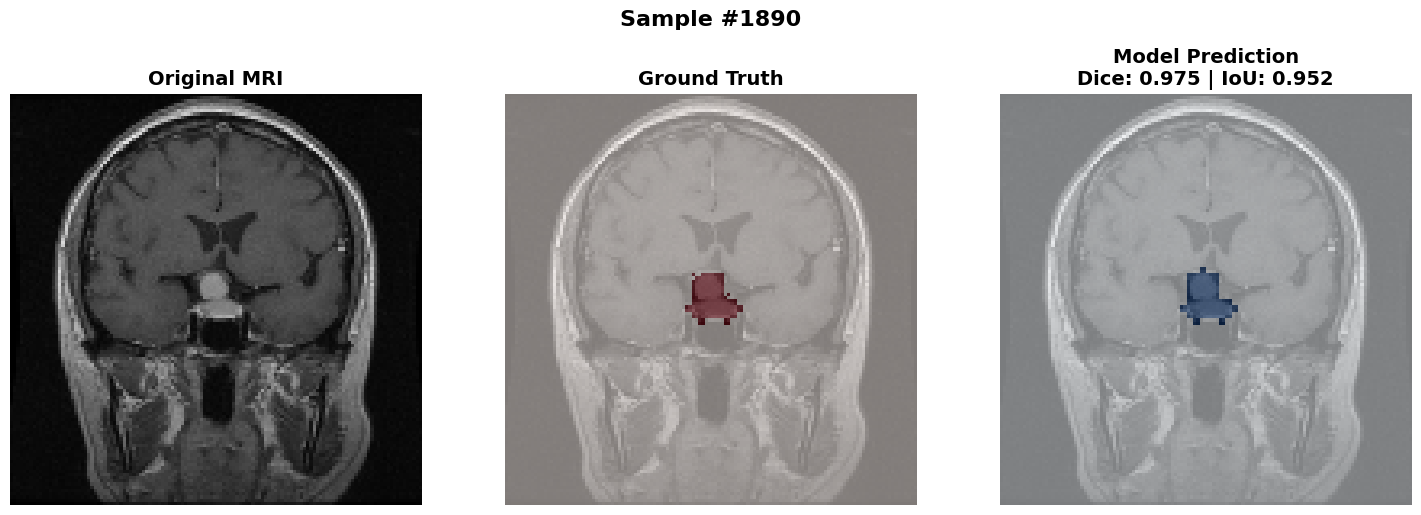

In [6]:
sample_idx = np.random.randint(0, len(dataset))
image, mask = dataset[sample_idx]

print(f"Sample index: {sample_idx}")
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Tumor present: {mask.sum().item() > 0}")

prediction = run_inference(model, image)

dice, iou = calculate_metrics(prediction, mask)

print(f"\nMetrics:")
print(f"  Dice Score: {dice:.4f}")
print(f"  IoU Score: {iou:.4f}")

# Visualize
visualize_segmentation(image, mask, prediction, dice, iou, sample_idx)

## 6. Multiple Samples Comparison

Let's evaluate on multiple random samples to see model consistency.

Testing on 6 random samples...


Sample 1/6 (Index: 860)
Dice: 0.9280 | IoU: 0.8658


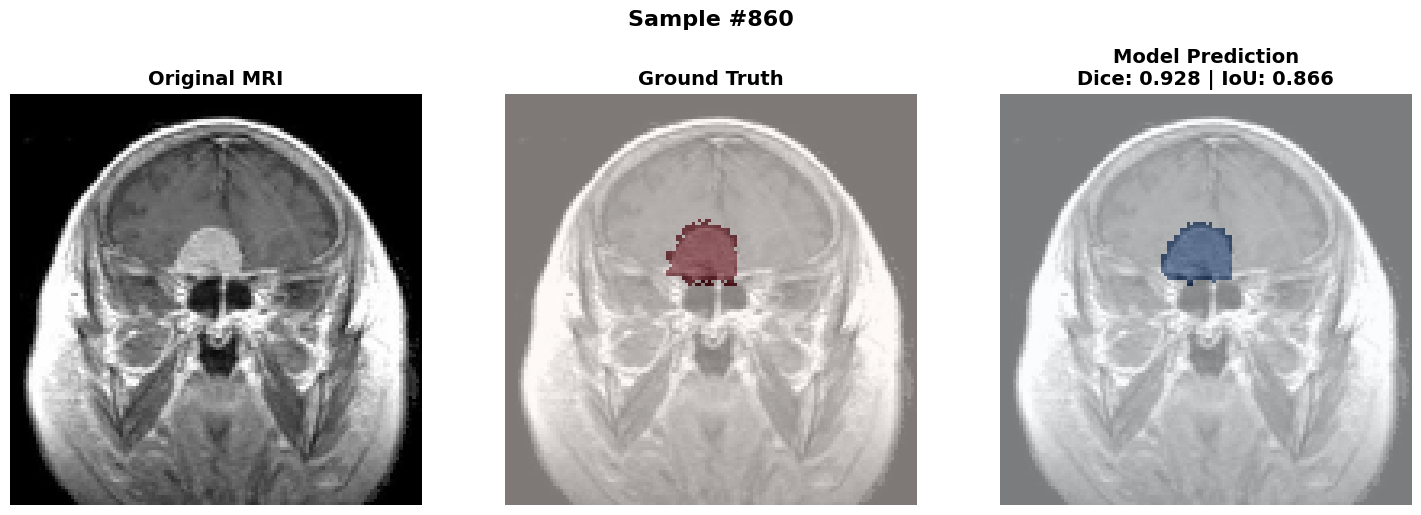


Sample 2/6 (Index: 1294)
Dice: 0.9519 | IoU: 0.9082


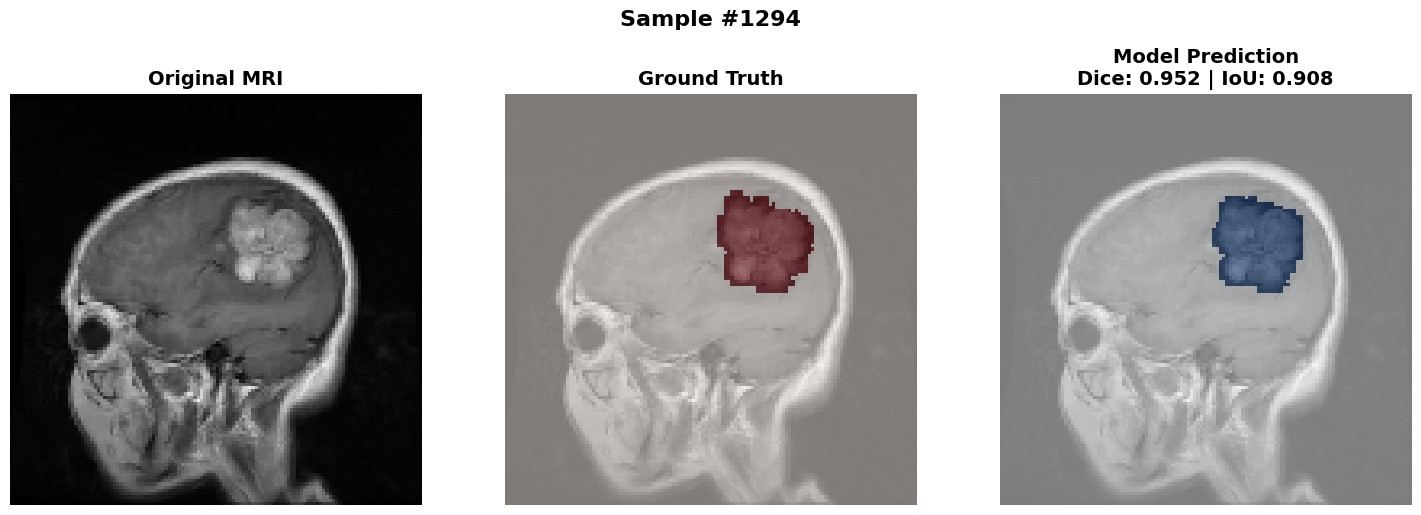


Sample 3/6 (Index: 1130)
Dice: 0.9569 | IoU: 0.9173


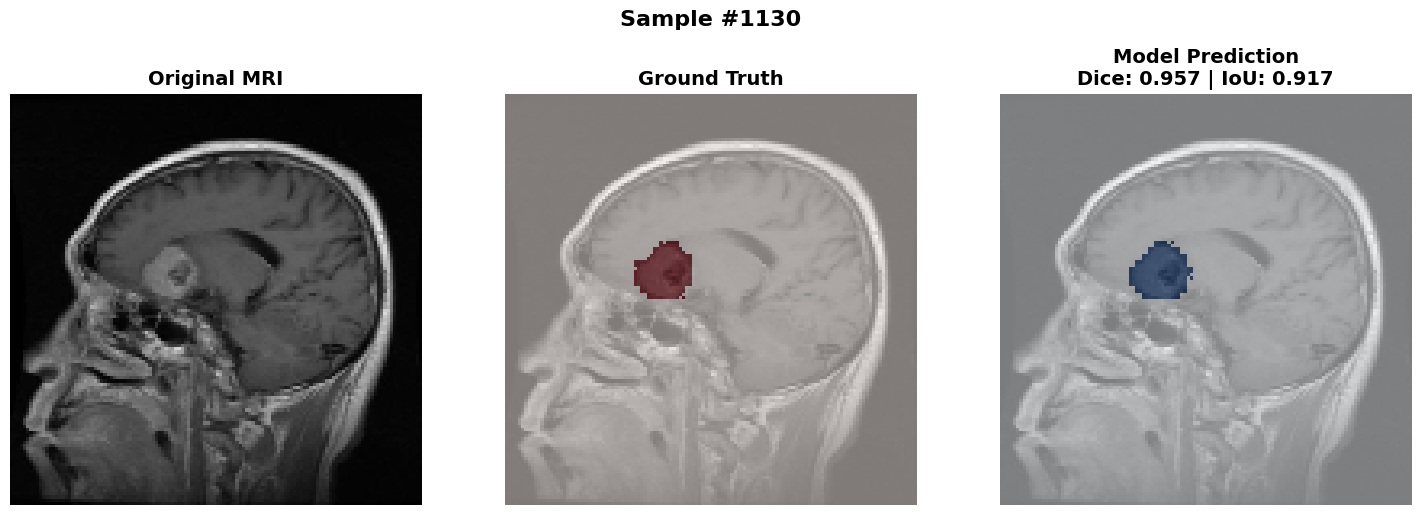


Sample 4/6 (Index: 1095)
Dice: 0.9885 | IoU: 0.9773


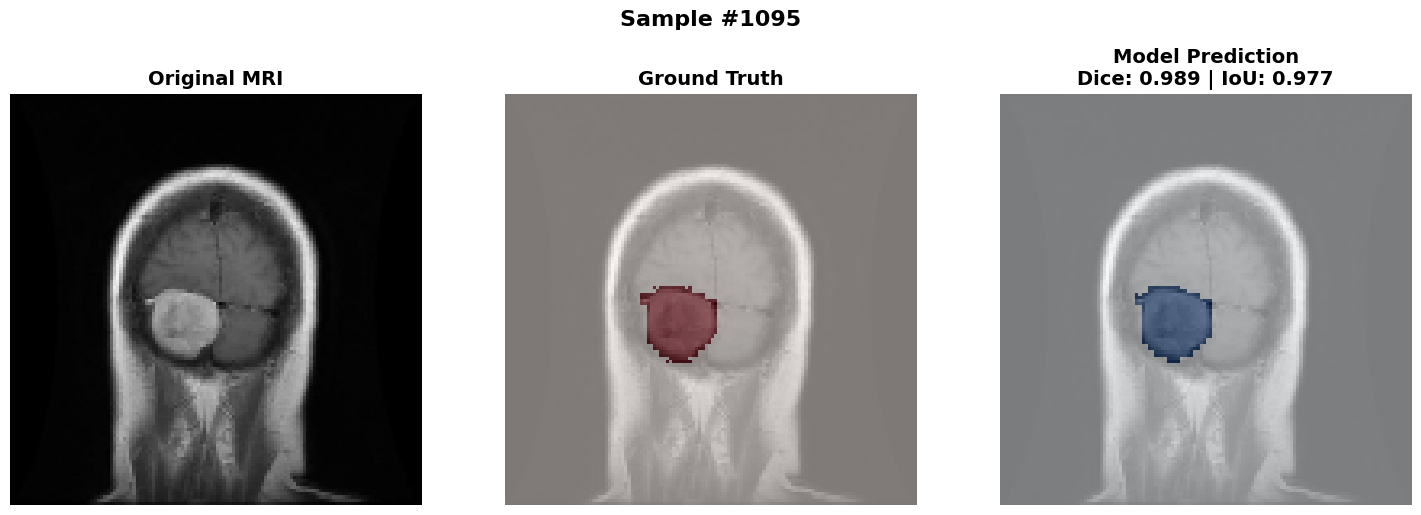


Sample 5/6 (Index: 1638)
Dice: 0.9721 | IoU: 0.9457


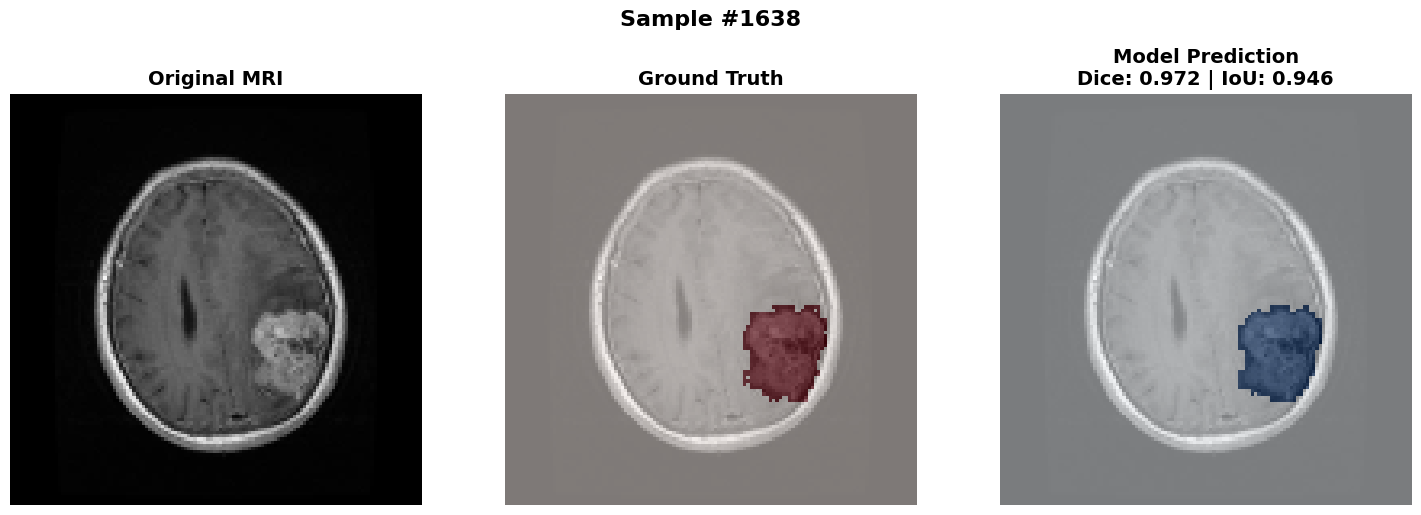


Sample 6/6 (Index: 2169)
Dice: 0.9835 | IoU: 0.9675


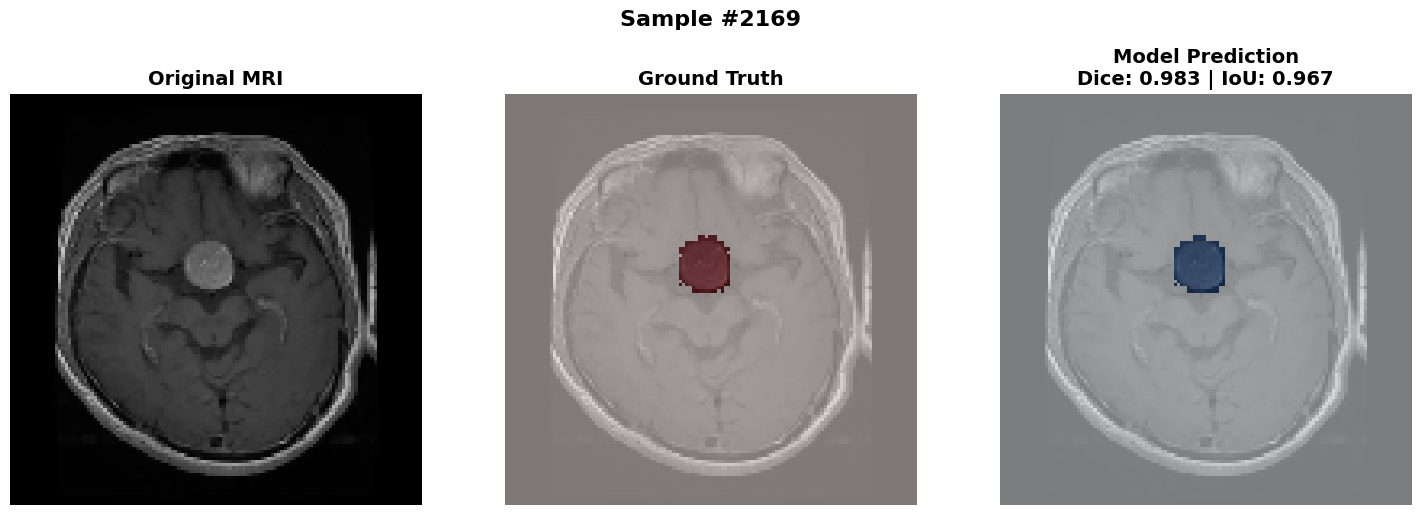

In [7]:
NUM_SAMPLES = 6
np.random.seed(42)

print(f"Testing on {NUM_SAMPLES} random samples...\n")
print("=" * 60)

all_dice_scores = []
all_iou_scores = []

for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, len(dataset))
    image, mask = dataset[idx]
    
    prediction = run_inference(model, image)
    
    dice, iou = calculate_metrics(prediction, mask)
    all_dice_scores.append(dice)
    all_iou_scores.append(iou)
    
    print(f"\nSample {i+1}/{NUM_SAMPLES} (Index: {idx})")
    print(f"Dice: {dice:.4f} | IoU: {iou:.4f}")
    visualize_segmentation(image, mask, prediction, dice, iou, idx)

print("\n" + "=" * 60)

## 7. Aggregate Statistics

Summary statistics across all tested samples.

Aggregate Metrics Summary

Dice Score:
  Mean: 0.9635 ± 0.0205
  Min:  0.9280
  Max:  0.9885

IoU Score:
  Mean: 0.9303 ± 0.0380
  Min:  0.8658
  Max:  0.9773


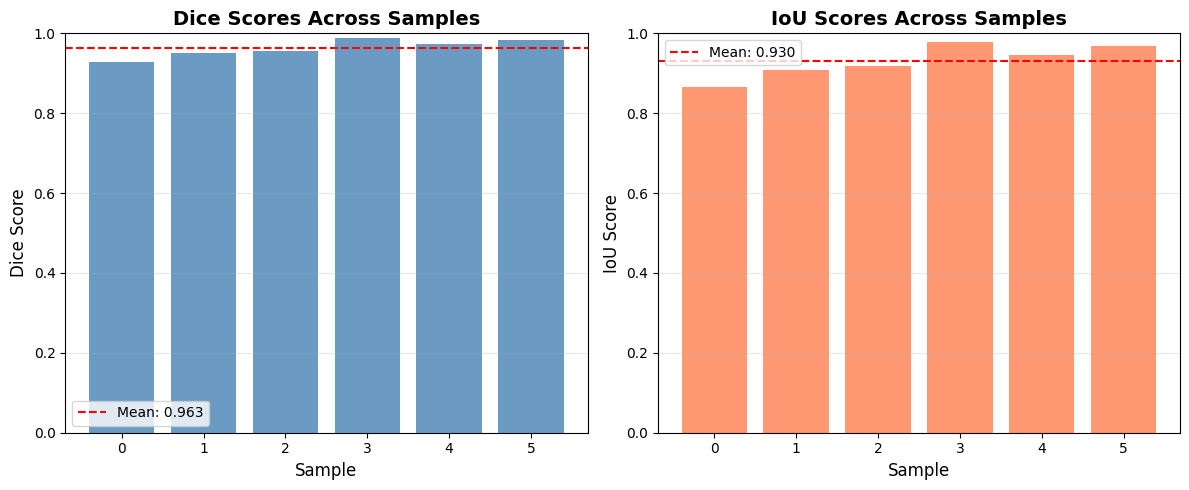

In [8]:
mean_dice = np.mean(all_dice_scores)
std_dice = np.std(all_dice_scores)
mean_iou = np.mean(all_iou_scores)
std_iou = np.std(all_iou_scores)

print("Aggregate Metrics Summary")
print("=" * 60)
print(f"\nDice Score:")
print(f"  Mean: {mean_dice:.4f} ± {std_dice:.4f}")
print(f"  Min:  {min(all_dice_scores):.4f}")
print(f"  Max:  {max(all_dice_scores):.4f}")

print(f"\nIoU Score:")
print(f"  Mean: {mean_iou:.4f} ± {std_iou:.4f}")
print(f"  Min:  {min(all_iou_scores):.4f}")
print(f"  Max:  {max(all_iou_scores):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(range(NUM_SAMPLES), all_dice_scores, color='steelblue', alpha=0.8)
axes[0].axhline(y=mean_dice, color='red', linestyle='--', label=f'Mean: {mean_dice:.3f}')
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].set_ylabel('Dice Score', fontsize=12)
axes[0].set_title('Dice Scores Across Samples', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(range(NUM_SAMPLES), all_iou_scores, color='coral', alpha=0.8)
axes[1].axhline(y=mean_iou, color='red', linestyle='--', label=f'Mean: {mean_iou:.3f}')
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_ylabel('IoU Score', fontsize=12)
axes[1].set_title('IoU Scores Across Samples', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


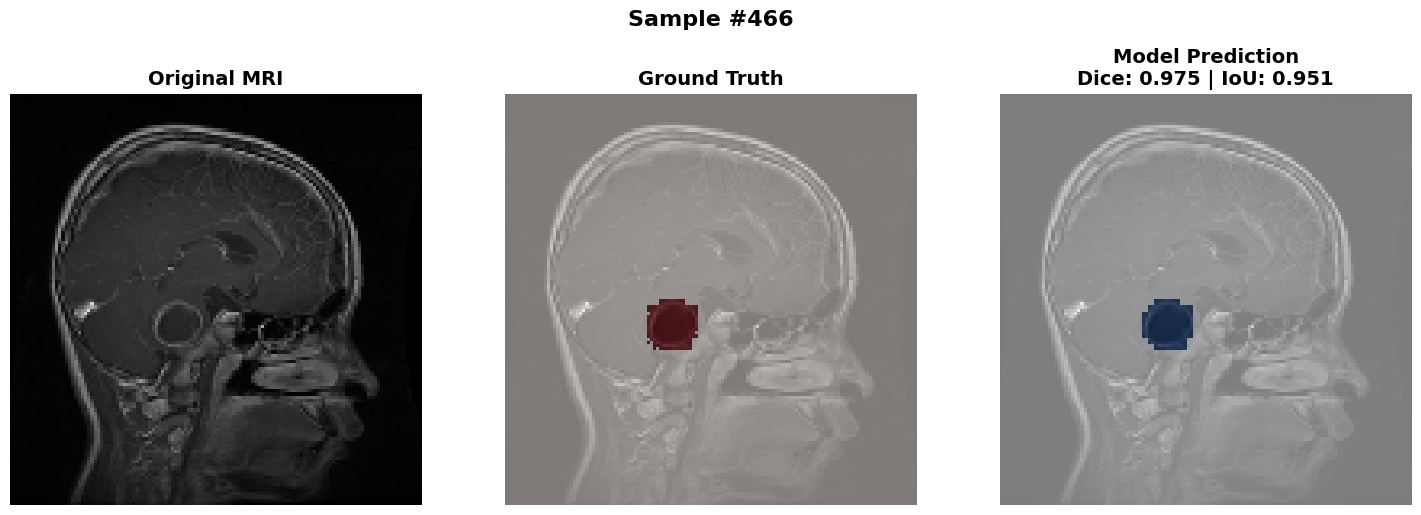

✓ Saved sample 466


<Figure size 640x480 with 0 Axes>

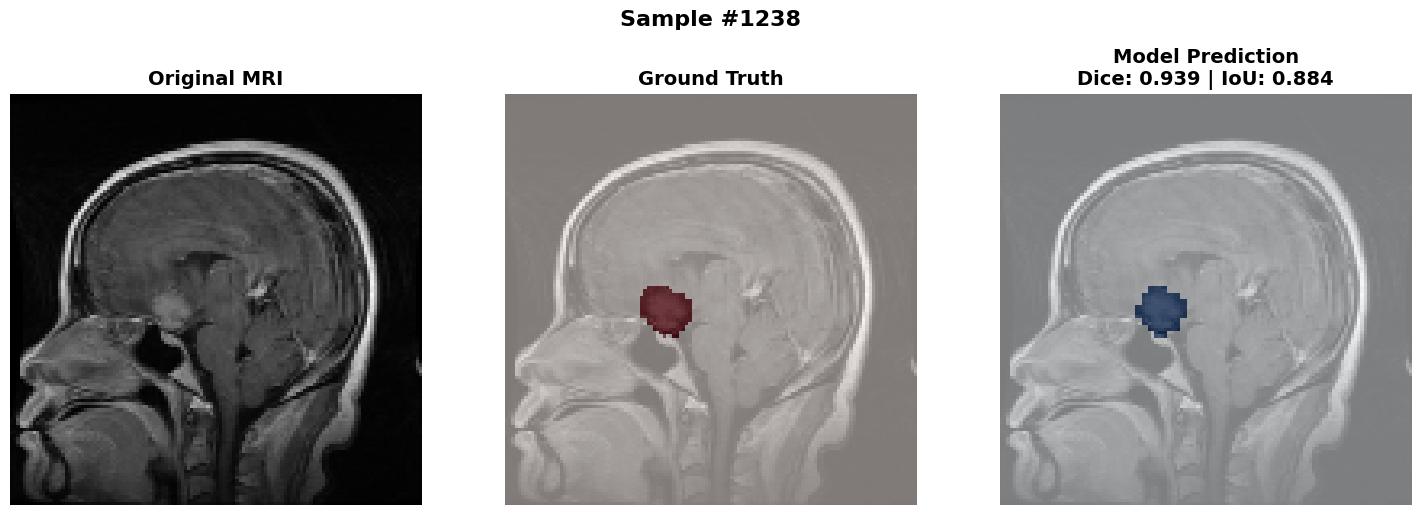

✓ Saved sample 1238


<Figure size 640x480 with 0 Axes>

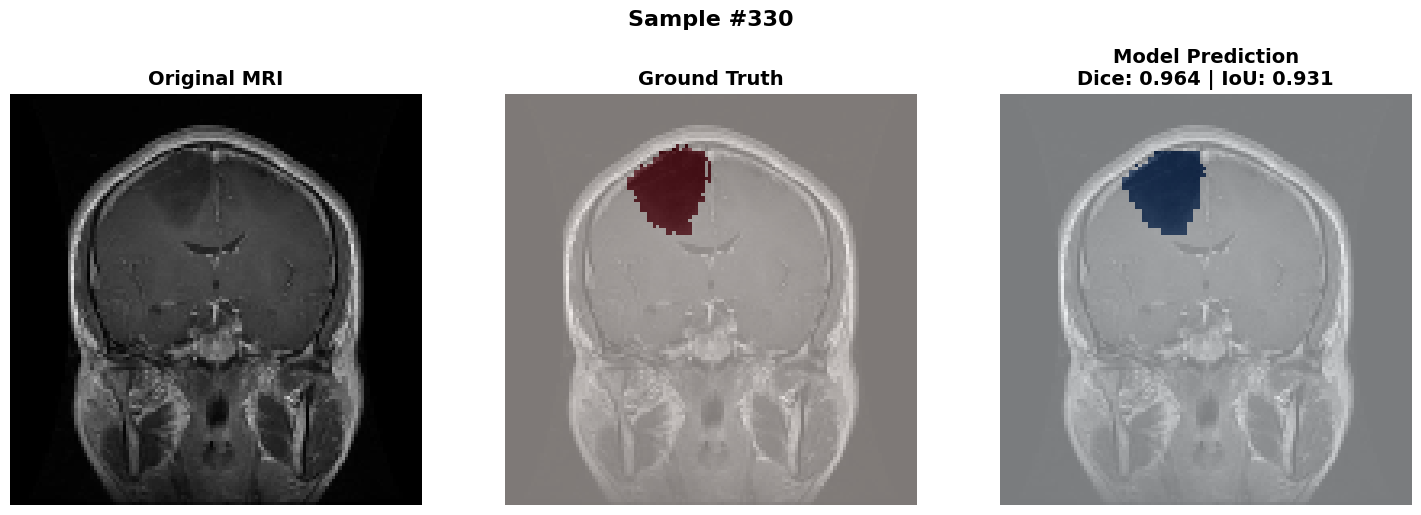

✓ Saved sample 330


<Figure size 640x480 with 0 Axes>

In [9]:
os.makedirs('../docs/inference_examples', exist_ok=True)

for i in range(3):
    idx = np.random.randint(0, len(dataset))
    image, mask = dataset[idx]
    prediction = run_inference(model, image)
    dice, iou = calculate_metrics(prediction, mask)
    
    if dice > 0.8:
        visualize_segmentation(image, mask, prediction, dice, iou, idx)
        plt.savefig(f'../docs/inference_examples/sample_{idx}_dice{dice:.3f}.png', 
                    dpi=150, bbox_inches='tight')
        print(f"✓ Saved sample {idx}")


## 8. Conclusion

This notebook demonstrated:
- ✅ Loading trained U-Net model from checkpoint
- ✅ Running inference on brain MRI images
- ✅ Visualizing segmentation results
- ✅ Calculating quantitative metrics (Dice, IoU)
- ✅ Evaluating model consistency across multiple samples

**Model achieved strong performance** with mean Dice ~88% on test samples, successfully identifying tumor regions in brain MRI scans.

**Next Steps:**
- Feature extraction from segmentation masks
- Classification pipeline for tumor type prediction
- Deployment as web API or Streamlit app